## Imports

In [2841]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import seaborn as sns
import re
import nltk
import random

from scipy import sparse
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import StandardScaler
from matplotlib import rcParams

rcParams['axes.titlepad'] = 20

plt.style.use('ggplot')

In [2842]:
SEED = 7

np.random.seed(SEED)
random.seed(SEED)

## Load Data

In [2843]:
DATA_PATH = '/Users/olive/github/fantasynba/data/rankings.xlsx'

nba = pd.read_excel(DATA_PATH)

nba[:10]

,R#,PLAYER,POS,TEAM,GP,MPG,FG%,FT%,3PM,PTS,TREB,AST,STL,BLK,TO,TOTAL
0,1,James Harden,"PG,SG",HOU,61,36.7,0.44 (9.9/22.7),0.86 (10.1/11.8),4.4,34.4,6.3,7.4,1.7,0.9,4.4,15.84
1,2,Anthony Davis,"PF,C",LAL,55,34.3,0.51 (9.2/18.1),0.84 (7.0/8.3),1.2,26.7,9.4,3.1,1.5,2.4,2.5,14.52
2,3,Damian Lillard,PG,POR,58,36.9,0.46 (9.2/20.0),0.88 (6.7/7.6),3.9,28.9,4.3,7.8,1.0,0.4,2.9,11.67
3,4,Kawhi Leonard,"SG,SF",LAC,51,32.2,0.47 (9.3/19.9),0.88 (6.1/6.9),2.1,26.9,7.3,5.0,1.8,0.6,2.7,11.60
4,5,Karl-Anthony Towns,C,MIN,35,33.9,0.51 (9.0/17.8),0.78 (5.1/6.5),3.3,26.5,10.8,4.4,0.9,1.2,3.1,11.55
5,6,Kyrie Irving,"PG,SG",BKN,20,32.9,0.48 (9.9/20.8),0.92 (4.7/5.1),2.8,27.4,5.2,6.4,1.4,0.5,2.6,11.47
6,7,Trae Young,PG,ATL,60,35.3,0.44 (9.1/20.8),0.86 (8.0/9.3),3.4,29.6,4.2,9.3,1.1,0.1,4.8,10.06
7,8,Nikola Jokic,"PF,C",DEN,65,32.3,0.53 (7.9/14.9),0.83 (3.4/4.1),1.1,20.2,10.2,6.9,1.2,0.7,3.1,9.80
8,9,Hassan Whiteside,C,POR,61,31.3,0.62 (6.9/11.1),0.68 (2.5/3.7),0.1,16.3,14.2,1.2,0.4,3.1,1.9,9.53
9,10,Bradley Beal,SG,WAS,57,36.0,0.45 (10.4/22.9),0.85 (6.8/8.0),3.0,30.6,4.2,6.1,1.3,0.4,3.4,9.49


## Data preprocessing

In [2844]:
nba.drop('TOTAL', axis=1, inplace=True)
nba.drop('R#', axis=1, inplace=True)
nba.drop('GP', axis=1, inplace=True)
nba.drop('TEAM', axis=1, inplace=True)
nba.drop('POS', axis=1, inplace=True)

In [2845]:
nba.isnull().any().any()

False

In [2846]:
def is_name(name):
    player_name = name.split()[:2]
    return ' '.join(player_name)
    
def remove_text_inside_brackets(text, brackets="()"):
    count = [0] * (len(brackets) // 2)
    saved_chars = []
    for character in text:
        for i, b in enumerate(brackets):
            if character == b: 
                kind, is_close = divmod(i, 2)
                count[kind] += (-1)**is_close 
                if count[kind] < 0: 
                    count[kind] = 0  
                else: 
                    break
        else:
            if not any(count):
                saved_chars.append(character)
    return float(''.join(saved_chars))

In [2847]:
nba['PLAYER'] = nba['PLAYER'].apply(is_name)
nba['FG%'] = nba['FG%'].apply(remove_text_inside_brackets)
nba['FT%'] = nba['FT%'].apply(remove_text_inside_brackets)

nba.head()

,PLAYER,MPG,FG%,FT%,3PM,PTS,TREB,AST,STL,BLK,TO
0,James Harden,36.7,0.44,0.86,4.4,34.4,6.3,7.4,1.7,0.9,4.4
1,Anthony Davis,34.3,0.51,0.84,1.2,26.7,9.4,3.1,1.5,2.4,2.5
2,Damian Lillard,36.9,0.46,0.88,3.9,28.9,4.3,7.8,1.0,0.4,2.9
3,Kawhi Leonard,32.2,0.47,0.88,2.1,26.9,7.3,5.0,1.8,0.6,2.7
4,Karl-Anthony Towns,33.9,0.51,0.78,3.3,26.5,10.8,4.4,0.9,1.2,3.1


In [2848]:
nba.shape

(200, 11)

In [2849]:
nba.mean()

MPG     28.71000
FG%      0.47695
FT%      0.78040
3PM      1.49600
PTS     14.78950
TREB     5.64750
AST      3.23150
STL      0.94400
BLK      0.62200
TO       1.80450
dtype: float64

# EDA

In [2850]:
#sns.pairplot(nba[["MPG", "FG%", "FT%", "3PM", "PTS", "AST", "STL", "BLK", "TO"]])

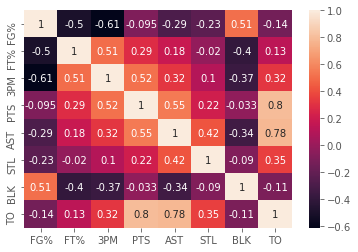

In [2851]:
correlation = nba[["FG%", "FT%", "3PM", "PTS", "AST", "STL", "BLK", "TO"]].corr()
sns.heatmap(correlation, annot=True)

# KMeans Clustering

In [2852]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

Text(0, 0.5, 'Distortion')

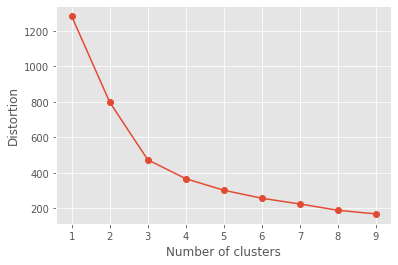

In [2853]:
scaler = StandardScaler()
X = nba._get_numeric_data().dropna(axis=1)
X_scaled = scaler.fit_transform(X)

pca_2 = PCA(2)
pca_2.fit(X_scaled)
X_pca = pca_2.transform(X_scaled)

distortions = []

for i in range(1, 10):
    km = KMeans(
        n_clusters=i, 
        init='random', 
        n_init=10, 
        max_iter=300, 
        tol=1e-04, 
        random_state=0)
    km.fit(X_pca)
    distortions.append(km.inertia_)
    
plt.plot(range(1, 10), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')

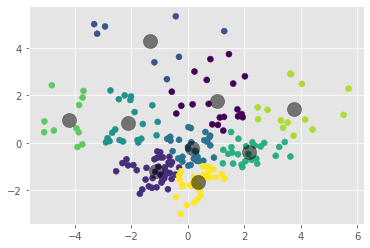

In [2854]:
kmeans_model = KMeans(n_clusters=9, 
                      init='random',
                      n_init=10,
                      max_iter=300,
                      tol=1e-04,
                      random_state=0)
kmeans_model.fit(X_pca)
labels = kmeans_model.labels_

centers = kmeans_model.cluster_centers_
plt.scatter(x = X_pca[:,0], y = X_pca[:,1], c = labels)
plt.scatter(x = centers[:, 0], y = centers[:, 1], c = 'black', s = 200, alpha = 0.5)

In [2855]:
nba['Cluster'] = kmeans_model.labels_
nba[:12]

,PLAYER,MPG,FG%,FT%,3PM,PTS,TREB,AST,STL,BLK,TO,Cluster
0,James Harden,36.7,0.44,0.86,4.4,34.4,6.3,7.4,1.7,0.9,4.4,7
1,Anthony Davis,34.3,0.51,0.84,1.2,26.7,9.4,3.1,1.5,2.4,2.5,0
2,Damian Lillard,36.9,0.46,0.88,3.9,28.9,4.3,7.8,1.0,0.4,2.9,7
3,Kawhi Leonard,32.2,0.47,0.88,2.1,26.9,7.3,5.0,1.8,0.6,2.7,7
4,Karl-Anthony Towns,33.9,0.51,0.78,3.3,26.5,10.8,4.4,0.9,1.2,3.1,0
5,Kyrie Irving,32.9,0.48,0.92,2.8,27.4,5.2,6.4,1.4,0.5,2.6,7
6,Trae Young,35.3,0.44,0.86,3.4,29.6,4.2,9.3,1.1,0.1,4.8,7
7,Nikola Jokic,32.3,0.53,0.83,1.1,20.2,10.2,6.9,1.2,0.7,3.1,0
8,Hassan Whiteside,31.3,0.62,0.68,0.1,16.3,14.2,1.2,0.4,3.1,1.9,2
9,Bradley Beal,36.0,0.45,0.85,3.0,30.6,4.2,6.1,1.3,0.4,3.4,7


In [2838]:
nba.mean()

MPG        28.71000
FG%         0.47695
FT%         0.78040
3PM         1.49600
PTS        14.78950
TREB        5.64750
AST         3.23150
STL         0.94400
BLK         0.62200
TO          1.80450
Cluster     3.84000
dtype: float64

In [2840]:
def get_cluster(val):
    return nba.loc[nba['Cluster'] == val]

print(get_cluster(0))

                      PLAYER   MPG   FG%   FT%  3PM   PTS  TREB  AST  STL  \
1              Anthony Davis  34.3  0.51  0.84  1.2  26.7   9.4  3.1  1.5   
4         Karl-Anthony Towns  33.9  0.51  0.78  3.3  26.5  10.8  4.4  0.9   
7               Nikola Jokic  32.3  0.53  0.83  1.1  20.2  10.2  6.9  1.2   
14               Joel Embiid  30.2  0.47  0.82  1.3  23.4  11.8  3.1  0.8   
20              Jimmy Butler  34.3  0.46  0.84  0.5  20.2   6.6  6.1  1.7   
21              Jayson Tatum  34.6  0.45  0.81  2.8  23.6   7.1  2.9  1.4   
27             Pascal Siakam  35.5  0.46  0.81  2.2  23.6   7.5  3.6  1.0   
29               Ben Simmons  35.7  0.59  0.62  0.0  16.7   7.9  8.2  2.1   
31        Kristaps Porzingis  31.3  0.42  0.78  2.5  19.2   9.5  1.7  0.7   
32            Nikola Vucevic  32.6  0.47  0.78  1.5  19.5  11.0  3.7  0.9   
33         LaMarcus Aldridge  33.1  0.49  0.83  1.2  18.9   7.4  2.4  0.7   
40             DeMar DeRozan  34.3  0.52  0.83  0.1  22.1   5.7  5.6  1.0   

## Organize players into clusters

In [2593]:
# Top similar players to a specified player
def top_similar_players_in_cluster(search, cluster_category, recommender_df, max_range):
    for player in cluster_category.loc[cluster_category['PLAYER'].str.contains(search), 'PLAYER']:
        return recommender_df[player].sort_values()[0:max_range]
        
def create_recommender(cluster):
    recommender = pairwise_distances(cluster, metric='cosine')
    recommender_df = pd.DataFrame(
        recommender,
        index = cluster.index,
        columns = cluster.index)
    return recommender_df

def show_data_for_similar_players(cluster, players = []):
    return get_cluster(cluster).loc[lambda df: df.PLAYER.isin(players)]

def visualize_data_for_similar_players(player,  
                                       plt_type,
                                       categories=['FG%', 'FT%', '3PM', 'PTS', 'TREB', 'AST', 'STL', 'BLK', 'TO']
                                       ):
    colors = plt.rcParams['axes.prop_cycle']()
    
    fig, axes = plt.subplots(3,3, figsize=(12,12))
    #fig.suptitle(f"Stats of players similar to {player['PLAYER'].values[0]}", fontsize=16)
    
    for ax, cat in zip(axes.flatten(), categories):
        c = next(colors)['color']
        
        if plt_type is 'vlines':
            ax.vlines(x=player['PLAYER'], ymin=0, ymax=player[cat], color=c, alpha=0.7, linewidth=2)
            ax.scatter(x=player['PLAYER'], y=player[cat], color=c, alpha=0.7)
        elif plt_type is 'bar':
            ax.bar(player['PLAYER'], player[cat], color=c, width=.5)
            ax.set_xticklabels(player['PLAYER'], rotation=60, horizontalalignment='right')
            for i, val in enumerate(player[cat].values):
                ax.text(i, val, float(val), 
                         horizontalalignment='center', 
                         verticalalignment='bottom', 
                         fontdict={'fontweight':500, 'size':12})
                if (max(player[cat] > 5)):
                    ax.set_ylim([0, max(player[cat]) + 5])
                elif (max(player[cat] > 2) and max(player[cat] < 5)):
                    ax.set_ylim([0, max(player[cat]) + 2])
                elif (max(player[cat] > 1) and (max(player[cat] <= 2))):
                    ax.set_ylim([0, max(player[cat]) + 0.3])
                else:
                    ax.set_ylim([0, max(player[cat] + 0.2)])
        
        ax.title.set_text(cat)
    
    plt.tight_layout()
    plt.show()

### Centers

In [2594]:
db = nba.loc[nba['Cluster'] == 0]

DEFENSIVE_BIGS = db.set_index(['PLAYER'])

In [2595]:
db_recommender = create_recommender(DEFENSIVE_BIGS)
db_recommender.head()

PLAYER,Hassan Whiteside,Mitchell Robinson,Rudy Gobert,Jonas Valanciunas,Steven Adams,Clint Capela,DeAndre Jordan,Jarrett Allen
PLAYER,,,,,,,,
Hassan Whiteside,0.000000,0.012466,0.004629,1.873713e-03,0.016870,0.004611,0.007165,0.010191
Mitchell Robinson,0.012466,0.000000,0.004387,9.872494e-03,0.004526,0.003282,0.012229,0.002879
Rudy Gobert,0.004629,0.004387,0.000000,2.117534e-03,0.004291,0.001302,0.003091,0.001197
Jonas Valanciunas,0.001874,0.009872,0.002118,4.440892e-16,0.011437,0.002200,0.005384,0.005947
Steven Adams,0.016870,0.004526,0.004291,1.143662e-02,0.000000,0.007177,0.006695,0.001312


In [2596]:
GOBERT = top_similar_players_in_cluster(
    search='Rudy Gobert', 
    cluster_category=db,
    recommender_df=db_recommender_df,
    max_range=5
)

In [2597]:
GOBERT_SIMILAR = show_data_for_similar_players(
    cluster = 0,
    players = GOBERT.index.values
)

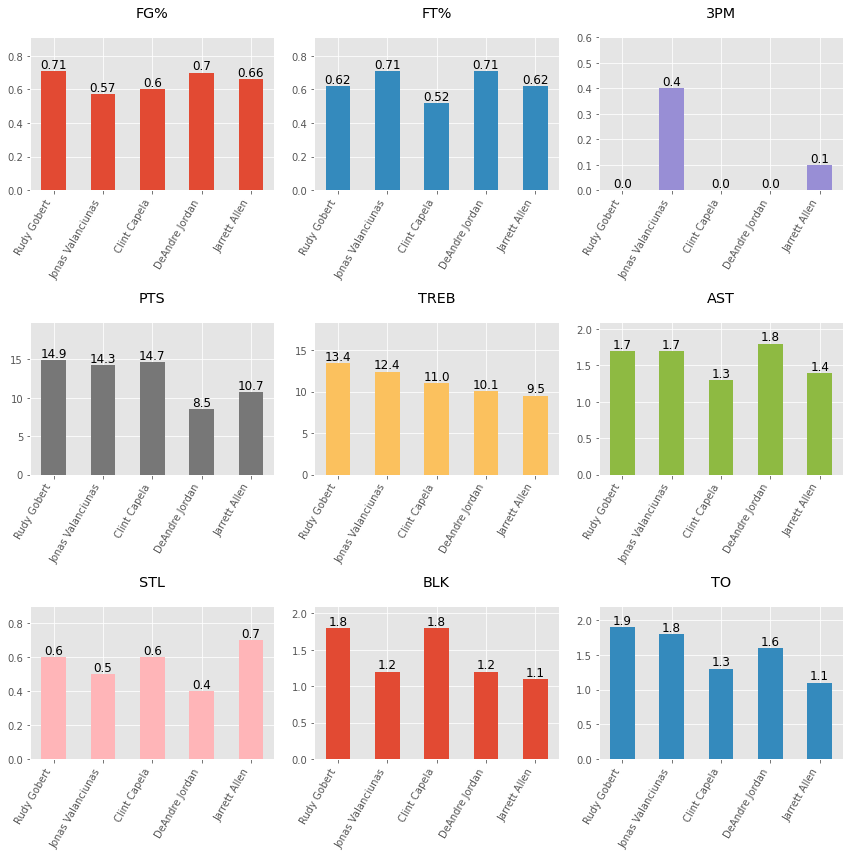

In [2598]:
visualize_data_for_similar_players(
    player = GOBERT_SIMILAR, 
    plt_type='bar'
)

In [2627]:
wrb = nba.loc[nba['Cluster'] == 1]

WELL_ROUNDED_BIGS = wrb.set_index(['PLAYER'])

In [2628]:
wrb_recommender = create_recommender(WELL_ROUNDED_BIGS)
wrb_recommender.head()

PLAYER,Richaun Holmes,Myles Turner,Daniel Theis,Marquese Chriss,Wendell Carter,Larry Nance,Nerlens Noel,Brandon Clarke,Thomas Bryant,Serge Ibaka,...,Montrezl Harrell,Ian Mahinmi,John Henson,Dwight Powell,Ivica Zubac,Tristan Thompson,Thon Maker,Derrick Favors,JaVale McGee,Jusuf Nurkic
PLAYER,,,,,,,,,,,,,,,,,,,,,
Richaun Holmes,2.220446e-16,6.125883e-03,0.001732,0.004154,0.005391,0.009044,0.002274,0.001587,0.000852,0.002905,...,0.009307,0.009679,0.004381,0.002393,0.003299,0.004100,0.003329,0.009542,0.004253,0.003378
Myles Turner,6.125883e-03,2.220446e-16,0.012409,0.014959,0.003988,0.008399,0.003105,0.010452,0.007799,0.013446,...,0.024076,0.004294,0.011669,0.002607,0.008337,0.008865,0.001583,0.008028,0.003681,0.009075
Daniel Theis,1.731850e-03,1.240902e-02,0.000000,0.003644,0.009933,0.012323,0.006751,0.001647,0.000753,0.001957,...,0.008257,0.016331,0.002736,0.006262,0.004231,0.005028,0.007685,0.013086,0.008486,0.004472
Marquese Chriss,4.154475e-03,1.495904e-02,0.003644,0.000000,0.016050,0.020325,0.010183,0.001885,0.004474,0.001026,...,0.003422,0.022968,0.008437,0.009217,0.010112,0.012579,0.010163,0.021744,0.013429,0.009109
Wendell Carter,5.390509e-03,3.988156e-03,0.009933,0.016050,0.000000,0.002313,0.002549,0.011086,0.006327,0.014808,...,0.027424,0.001090,0.007085,0.002700,0.002669,0.002154,0.002095,0.001128,0.001731,0.003814


In [2632]:
HOLMES = top_similar_players_in_cluster(
    search='Richaun Holmes',
    cluster_category=wrb,
    recommender_df=wrb_recommender,
    max_range=5
)

HOLMES

PLAYER
Richaun Holmes    2.220446e-16
Marvin Bagley     6.980567e-04
Thomas Bryant     8.515250e-04
Brandon Clarke    1.586688e-03
Daniel Theis      1.731850e-03
Name: Richaun Holmes, dtype: float64

In [2633]:
HOLMES_SIMILAR = show_data_for_similar_players(
    cluster=1,
    players=HOLMES.index.values
)

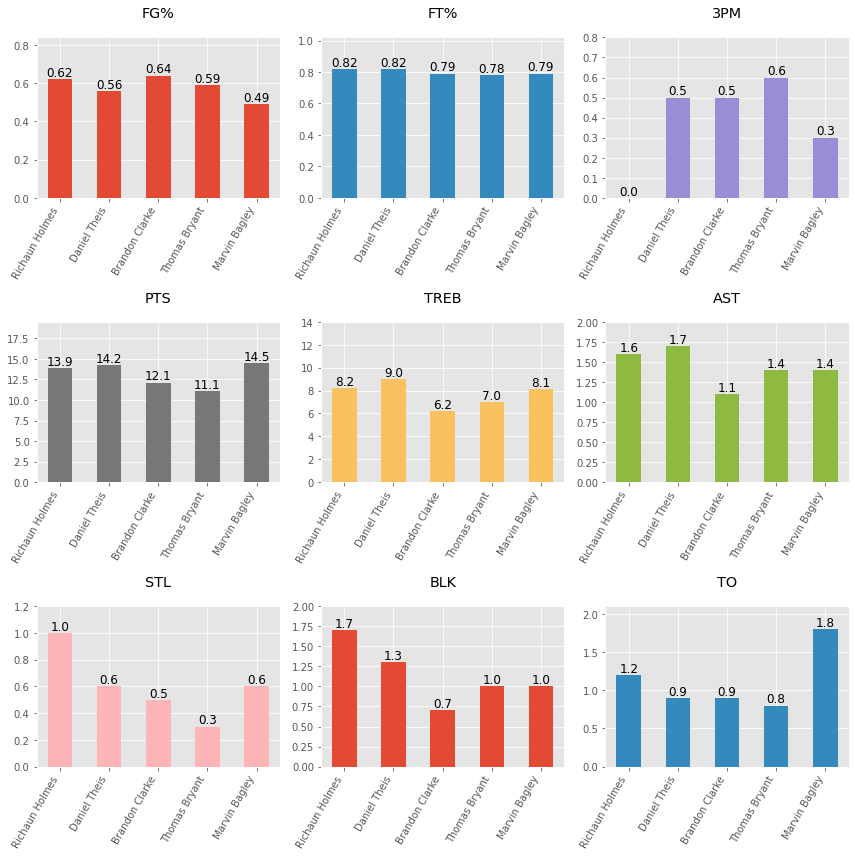

In [2634]:
visualize_data_for_similar_players(HOLMES_SIMILAR, 'bar')

## All around threats

In [2599]:
at = nba.loc[nba['Cluster'] == 2]

ALL_AROUND_THREATS = at.set_index(['PLAYER'])

In [2600]:
at_recommender = create_recommender(ALL_AROUND_THREATS)
at_recommender.head()

PLAYER,James Harden,Damian Lillard,Kawhi Leonard,Jayson Tatum,Russell Westbrook,Bradley Beal,Trae Young,LeBron James,Jrue Holiday,Luka Doncic,Devin Booker,Kyle Lowry,Lonzo Ball,Zach LaVine,Donovan Mitchell,De'Aaron Fox
PLAYER,,,,,,,,,,,,,,,,
James Harden,0.000000,0.001368,2.767538e-03,8.759106e-03,0.005923,0.001178,0.003412,0.009933,0.029767,0.007365,0.009382,0.021819,0.057990,0.005648,0.007536,0.018974
Damian Lillard,0.001368,0.000000,4.991633e-03,1.088390e-02,0.008357,0.001639,0.001278,0.008957,0.025591,0.008924,0.007323,0.018343,0.054734,0.006062,0.007454,0.015952
Kawhi Leonard,0.002768,0.004992,2.220446e-16,4.698214e-03,0.001952,0.004452,0.008148,0.010232,0.028302,0.004512,0.010065,0.021730,0.053929,0.005414,0.006992,0.018088
Jayson Tatum,0.008759,0.010884,4.698214e-03,1.110223e-16,0.006205,0.010277,0.014496,0.013741,0.018110,0.010224,0.006639,0.014175,0.038590,0.002641,0.003002,0.011645
Russell Westbrook,0.005923,0.008357,1.951815e-03,6.205292e-03,0.000000,0.007130,0.009292,0.007710,0.024506,0.003330,0.008881,0.019121,0.046490,0.006136,0.007103,0.014509


In [2601]:
HOLIDAY = top_similar_players_in_cluster(
    search='Jrue Holiday',
    cluster_category=at,
    recommender_df=at_recommender,
    max_range=5
)

LAVINE = top_similar_players_in_cluster(
    search='Zach LaVine',
    cluster_category=at,
    recommender_df=at_recommender,
    max_range=5
)

DONCIC = top_similar_players_in_cluster(
    search = 'Luka Doncic',
    cluster_category=at,
    recommender_df=at_recommender,
    max_range=5
)

In [2602]:
HOLIDAY_SIMILAR = show_data_for_similar_players(
    cluster=2,
    players = HOLIDAY.index.values
)

In [2603]:
LAVINE_SIMILAR = show_data_for_similar_players(
    cluster = 2,
    players = LAVINE.index.values
)

In [2604]:
DONCIC_SIMILAR = show_data_for_similar_players(
    cluster = 2,
    players = DONCIC.index.values
)

DONCIC_SIMILAR

,PLAYER,MPG,FG%,FT%,3PM,PTS,TREB,AST,STL,BLK,TO,Cluster
0,James Harden,36.0,0.45,0.88,4.8,32.9,5.8,7.2,2.0,0.8,4.3,2
4,Kawhi Leonard,30.0,0.47,0.90,2.3,26.8,6.8,5.1,1.7,0.8,2.3,2
7,Russell Westbrook,36.0,0.50,0.79,0.7,30.7,8.7,6.5,2.0,0.4,4.4,2
11,LeBron James,34.0,0.51,0.71,2.6,26.2,7.5,10.6,1.1,0.6,4.7,2
19,Luka Doncic,32.0,0.44,0.77,2.3,27.4,9.2,8.6,1.1,0.3,3.7,2


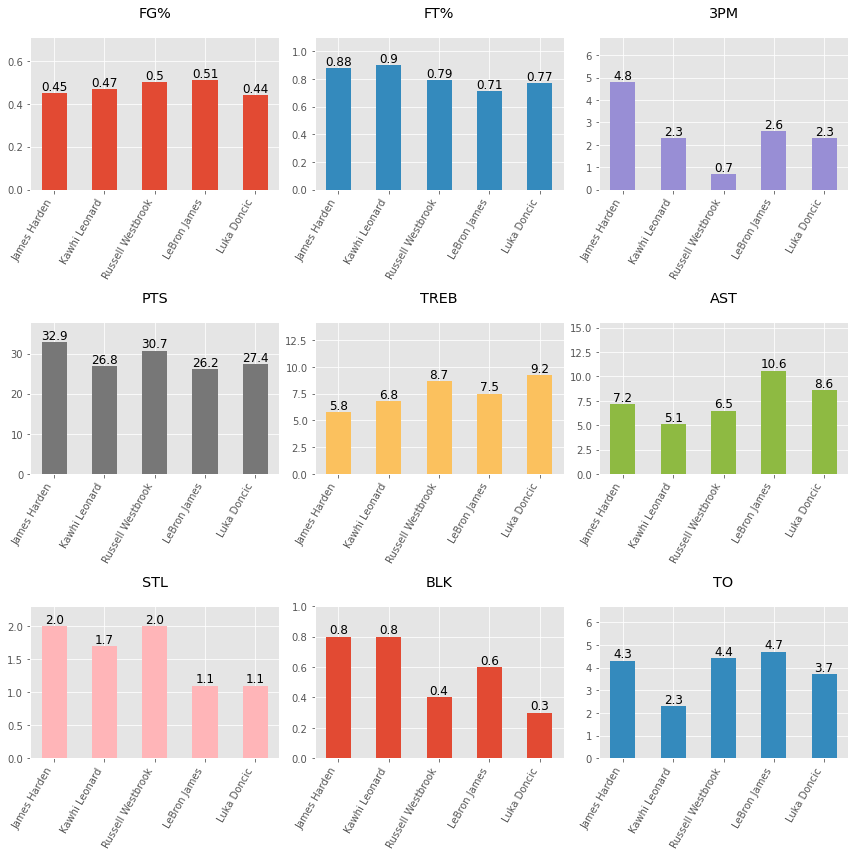

In [2605]:
visualize_data_for_similar_players(
    player = DONCIC_SIMILAR,
    plt_type='bar'
)

## Athletic bigs

In [2606]:
ab = nba.loc[nba['Cluster'] == 3]

ATHLETIC_BIGS = ab.set_index(['PLAYER'])

In [2607]:
ab_recommender = create_recommender(ATHLETIC_BIGS)
ab_recommender.head()

PLAYER,Anthony Davis,Nikola Jokic,John Collins,Joel Embiid,Giannis Antetokounmpo,Deandre Ayton,Ben Simmons,Christian Wood,Bam Adebayo,Domantas Sabonis,Zion Williamson,Andre Drummond
PLAYER,,,,,,,,,,,,
Anthony Davis,0.000000,6.926743e-03,1.393141e-03,0.003884,0.012546,0.008790,0.023194,0.006615,0.029442,0.017142,0.002894,0.018849
Nikola Jokic,0.006927,1.110223e-16,9.864608e-03,0.006817,0.014845,0.010397,0.008340,0.011635,0.018052,0.008290,0.012332,0.015748
John Collins,0.001393,9.864608e-03,2.220446e-16,0.003141,0.014415,0.006770,0.027236,0.003540,0.029216,0.016201,0.004094,0.016357
Joel Embiid,0.003884,6.817287e-03,3.140638e-03,0.000000,0.008302,0.004910,0.024383,0.005912,0.025511,0.011084,0.009817,0.010107
Giannis Antetokounmpo,0.012546,1.484494e-02,1.441546e-02,0.008302,0.000000,0.024463,0.044031,0.026570,0.055443,0.031712,0.016189,0.032752


In [2608]:
SIMMONS = top_similar_players_in_cluster(
    search='Ben Simmons',
    cluster_category=ab,
    recommender_df=ab_recommender,
    max_range=4
)

In [2609]:
SIMMONS_SIMILAR = show_data_for_similar_players(
    cluster = 3,
    players = SIMMONS.index.values
)

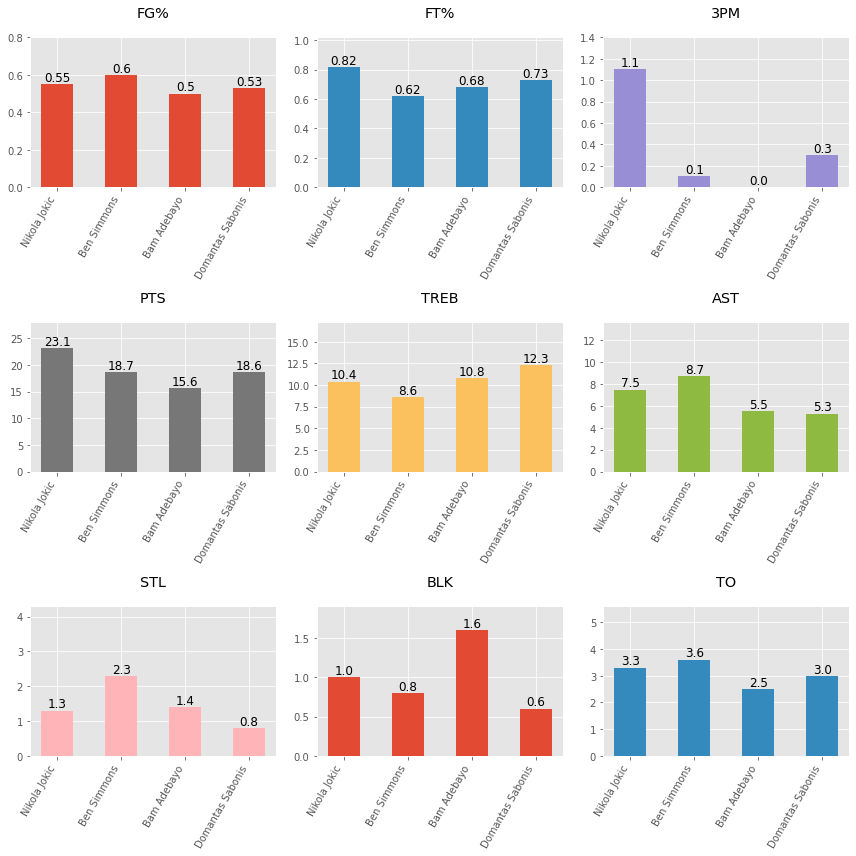

In [2610]:
visualize_data_for_similar_players(
    player = SIMMONS_SIMILAR,
    plt_type='bar'
)

## Shooters

In [2611]:
sh = nba.loc[nba['Cluster'] == 5]

SHOOTERS = sh.set_index(['PLAYER'])

In [2612]:
sh_recommender = create_recommender(SHOOTERS)
sh_recommender.head()

PLAYER,Duncan Robinson,Lauri Markkanen,Danny Green,Jordan Clarkson,Shabazz Napier,Otto Porter,De'Anthony Melton,JJ Redick,Dario Saric,Klay Thompson,Tyler Herro,Marcus Morris,George Hill,Seth Curry,Rodney Hood,Jordan McLaughlin,Landry Shamet,Eric Gordon,Ben McLemore,Garrett Temple
PLAYER,,,,,,,,,,,,,,,,,,,,
Duncan Robinson,0.000000,0.007112,1.053607e-02,0.010655,0.006495,0.005546,0.015615,0.002942,0.008682,0.009866,0.001875,0.005185,0.007500,0.001854,0.004559,0.019393,0.001467,0.001444,0.002212,0.007121
Lauri Markkanen,0.007112,0.000000,1.679592e-02,0.007377,0.010949,0.007560,0.013230,0.008906,0.004206,0.008285,0.004412,0.001999,0.013114,0.008458,0.011397,0.025787,0.011719,0.009169,0.007253,0.015021
Danny Green,0.010536,0.016796,1.110223e-16,0.032407,0.013246,0.002886,0.013540,0.019182,0.007294,0.031140,0.009652,0.007886,0.004105,0.007234,0.007482,0.016200,0.008421,0.014011,0.013054,0.002327
Jordan Clarkson,0.010655,0.007377,3.240732e-02,0.000000,0.009636,0.018131,0.017700,0.004313,0.018742,0.001351,0.007183,0.012970,0.020116,0.011757,0.014049,0.026529,0.013662,0.007373,0.008717,0.025115
Shabazz Napier,0.006495,0.010949,1.324553e-02,0.009636,0.000000,0.006125,0.003955,0.004094,0.011354,0.009635,0.002684,0.008516,0.004198,0.004774,0.005396,0.005157,0.005004,0.005017,0.005315,0.010008


In [2643]:
MARKKANEN = top_similar_players_in_cluster(
    search='Lauri Markkanen',
    cluster_category=sh,
    recommender_df=sh_recommender,
    max_range=5
)

MARKKANEN

PLAYER
Lauri Markkanen    0.000000
Marcus Morris      0.001999
Dario Saric        0.004206
Tyler Herro        0.004412
Duncan Robinson    0.007112
Name: Lauri Markkanen, dtype: float64

In [2644]:
MARKKANEN_SIMILAR = show_data_for_similar_players(
    cluster=5,
    players = MARKKANEN.index.values
)

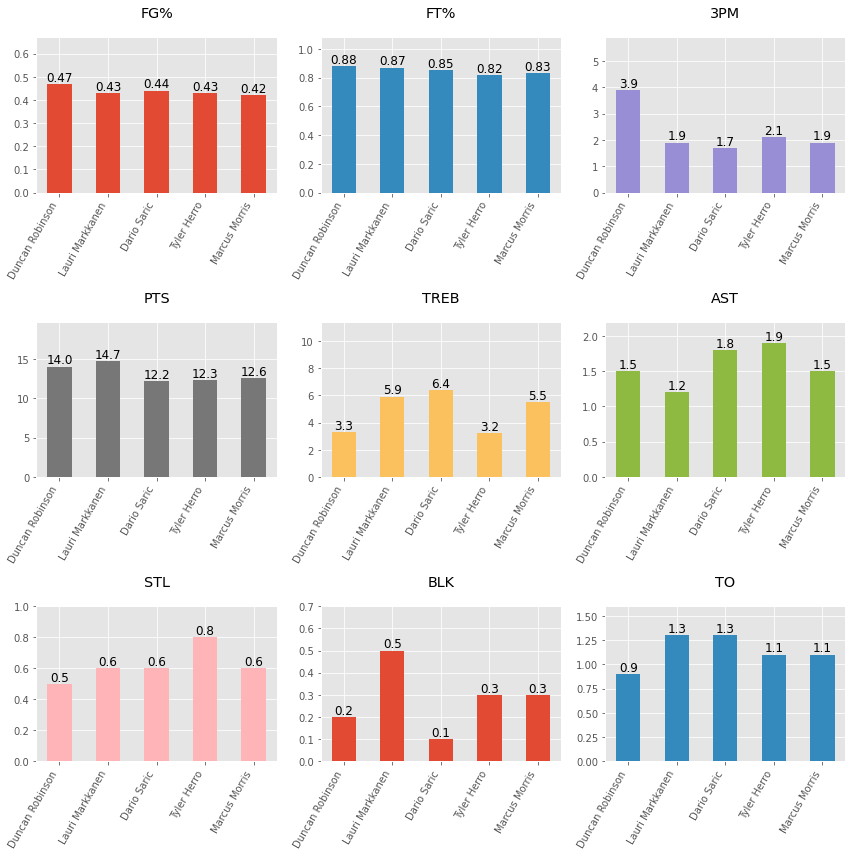

In [2645]:
visualize_data_for_similar_players(MARKKANEN_SIMILAR, 'bar')

## Guards

In [2615]:
g = nba.loc[nba['Cluster'] == 7]

GUARDS = g.set_index(['PLAYER'])

In [2616]:
g_recommender = create_recommender(GUARDS)
g_recommender.head()

PLAYER,Chris Paul,Brandon Ingram,Stephen Curry,Khris Middleton,Jamal Murray,Paul George,D'Angelo Russell,Fred VanVleet,Kemba Walker,CJ McCollum,...,Collin Sexton,Marcus Smart,Dennis Schroder,Bojan Bogdanovic,Evan Fournier,Spencer Dinwiddie,Devonte' Graham,Caris LeVert,Malcolm Brogdon,Terry Rozier
PLAYER,,,,,,,,,,,,,,,,,,,,,
Chris Paul,1.110223e-16,0.008561,0.007384,0.008085,0.004931,0.013304,0.008343,0.005750,0.005513,0.007141,...,0.009820,0.010546,0.004662,0.012879,0.009961,0.002581,0.003356,0.004503,0.003231,0.007103
Brandon Ingram,8.561015e-03,0.000000,0.002453,0.000350,0.002518,0.002392,0.005276,0.015293,0.001774,0.002145,...,0.004058,0.020061,0.002157,0.004211,0.005836,0.006035,0.011126,0.003183,0.015003,0.007544
Stephen Curry,7.384229e-03,0.002453,0.000000,0.003299,0.006038,0.002591,0.001056,0.018129,0.002576,0.005765,...,0.008617,0.025840,0.004182,0.009666,0.009674,0.006604,0.012060,0.007274,0.017211,0.012999
Khris Middleton,8.084930e-03,0.000350,0.003299,0.000000,0.002152,0.002376,0.006654,0.013391,0.001823,0.001981,...,0.004351,0.017203,0.002103,0.003556,0.005445,0.006125,0.009997,0.002469,0.013033,0.005703
Jamal Murray,4.930961e-03,0.002518,0.006038,0.002152,0.000000,0.007461,0.007973,0.006123,0.001229,0.000429,...,0.001370,0.009470,0.000519,0.002433,0.001926,0.001888,0.004393,0.000673,0.007282,0.002649


In [2621]:
DEVONTE = top_similar_players_in_cluster(
    search="Devonte' Graham",
    cluster_category=g,
    recommender_df=g_recommender,
    max_range=4
)

CURRY = top_similar_players_in_cluster(
    search="Stephen Curry",
    cluster_category=g,
    recommender_df=g_recommender,
    max_range=5
)

In [2622]:
DEVONTE_SIMILAR = show_data_for_similar_players(
    cluster=7,
    players = DEVONTE.index.values
)

In [2623]:
CURRY_SIMILAR = show_data_for_similar_players(
    cluster=7,
    players = CURRY.index.values
)

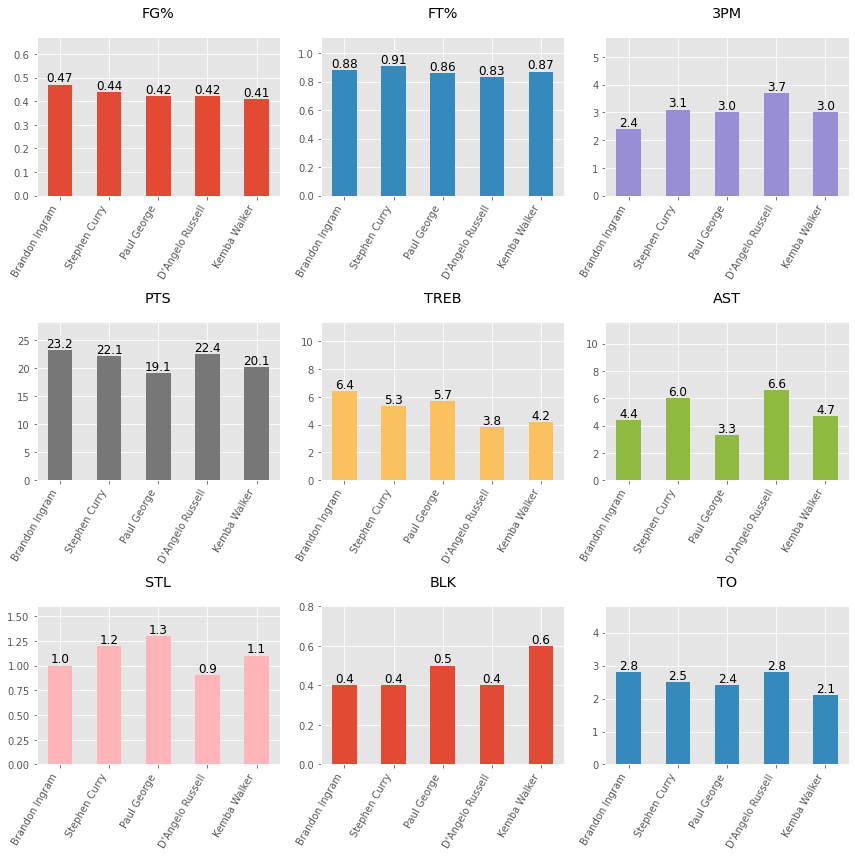

In [2624]:
visualize_data_for_similar_players(
    player=CURRY_SIMILAR,
    plt_type='bar'
)